## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
!nvidia-smi

Sat Sep 19 20:27:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8    N/A /  N/A |   2201MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 0.01
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [0.95, 0.75, 0.55]
ISNESTEROV = [True, False]

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for mmt in MOMENTUM:
    for isnes in ISNESTEROV:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with LR = %.6f and IsNESTEROV = %s" % (mmt, isnes))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=isnes, momentum=mmt)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-mmt-%s-NESTEROV-%s" % (str(mmt), str(isnes))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with LR = 0.950000 and IsNESTEROV = True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50

Epoch 49/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3852 - accuracy: 0.8594 - val_loss: 2.3423 - val_accuracy: 0.5064
Epoch 50/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3731 - accuracy: 0.8666 - val_loss: 2.3462 - val_accuracy: 0.5146
Experiment with LR = 0.950000 and IsNESTEROV = False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________

Epoch 47/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.6723 - accuracy: 0.7586 - val_loss: 1.6528 - val_accuracy: 0.5357
Epoch 48/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.6348 - accuracy: 0.7704 - val_loss: 1.6848 - val_accuracy: 0.5246
Epoch 49/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.6336 - accuracy: 0.7713 - val_loss: 1.7558 - val_accuracy: 0.5278
Epoch 50/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.6269 - accuracy: 0.7732 - val_loss: 1.7650 - val_accuracy: 0.5240
Experiment with LR = 0.750000 and IsNESTEROV = True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________

Epoch 45/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.8327 - accuracy: 0.7101 - val_loss: 1.4733 - val_accuracy: 0.5093
Epoch 46/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.8160 - accuracy: 0.7144 - val_loss: 1.5174 - val_accuracy: 0.5158
Epoch 47/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.8069 - accuracy: 0.7183 - val_loss: 1.6539 - val_accuracy: 0.4940
Epoch 48/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.7871 - accuracy: 0.7239 - val_loss: 1.4234 - val_accuracy: 0.5321
Epoch 49/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.7872 - accuracy: 0.7235 - val_loss: 1.6780 - val_accuracy: 0.4847
Epoch 50/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.7606 - accuracy: 0.7339 - val_loss: 1.9350 - val_accuracy: 0.4577
Experiment with LR = 0.750000 and IsNESTEROV = False
Model: "model_1"
__________________________________________

Epoch 43/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.8463 - accuracy: 0.7023 - val_loss: 1.5270 - val_accuracy: 0.5058
Epoch 44/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.8455 - accuracy: 0.7009 - val_loss: 1.3899 - val_accuracy: 0.5376
Epoch 45/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.8243 - accuracy: 0.7112 - val_loss: 1.4516 - val_accuracy: 0.5234
Epoch 46/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.8077 - accuracy: 0.7170 - val_loss: 1.4261 - val_accuracy: 0.5282
Epoch 47/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7981 - accuracy: 0.7194 - val_loss: 1.4280 - val_accuracy: 0.5276
Epoch 48/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.7907 - accuracy: 0.7195 - val_loss: 1.5997 - val_accuracy: 0.5040
Epoch 49/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.7638 - accuracy: 0.7315 - val_

Epoch 41/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.0934 - accuracy: 0.6166 - val_loss: 1.3852 - val_accuracy: 0.5145
Epoch 42/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.0822 - accuracy: 0.6222 - val_loss: 1.3134 - val_accuracy: 0.5370
Epoch 43/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.0733 - accuracy: 0.6229 - val_loss: 1.3485 - val_accuracy: 0.5253
Epoch 44/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.0569 - accuracy: 0.6294 - val_loss: 1.4048 - val_accuracy: 0.5101
Epoch 45/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.0507 - accuracy: 0.6290 - val_loss: 1.4557 - val_accuracy: 0.5008
Epoch 46/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.0438 - accuracy: 0.6341 - val_loss: 1.4337 - val_accuracy: 0.4958
Epoch 47/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.0362 - accuracy: 0.6363 - val_

Epoch 39/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.0843 - accuracy: 0.6211 - val_loss: 1.4079 - val_accuracy: 0.5086
Epoch 40/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.0776 - accuracy: 0.6206 - val_loss: 1.3321 - val_accuracy: 0.5309
Epoch 41/50
50000/50000 [==============================] - 2s 48us/step - loss: 1.0666 - accuracy: 0.6272 - val_loss: 1.5368 - val_accuracy: 0.4769
Epoch 42/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.0576 - accuracy: 0.6283 - val_loss: 1.4956 - val_accuracy: 0.4907
Epoch 43/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.0443 - accuracy: 0.6338 - val_loss: 1.3896 - val_accuracy: 0.5111
Epoch 44/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.0376 - accuracy: 0.6357 - val_loss: 1.3596 - val_accuracy: 0.5264
Epoch 45/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.0265 - accuracy: 0.6394 - val_

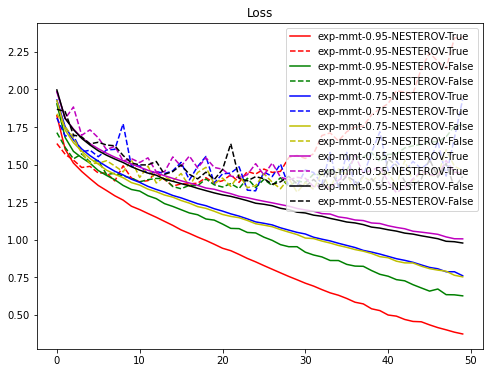

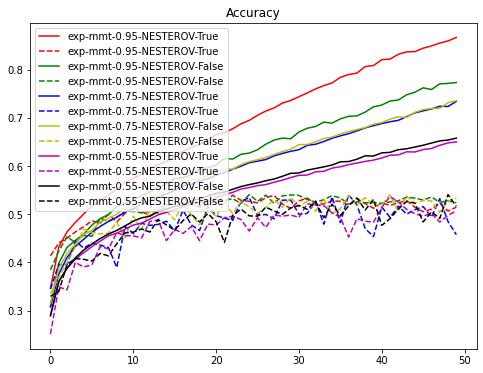

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()